## 1. Load the dataset and explore the variables.

### importing libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTENC

import matplotlib.pyplot as plt
import seaborn as sns

### downloading data

In [2]:
data = pd.read_csv('files_for_lab/customer_churn.csv')

In [3]:
print(data.shape)
pd.set_option('display.max_columns', 21)
data.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### standardizing column names

In [4]:
def std_col_names(data):
    '''function to standardize column_names'''  
    
    import re
    data_c = data.copy()
    
    #changing header names
    cols = []
    #lowering cases and replacing space with underscore
    for i in data_c.columns: cols.append(re.sub('([a-z])([A-Z])', r'\1_\2', i).lower())
    data_c.columns = cols 
    
    return data_c

data = std_col_names(data)

### check customer_id duplicates

In [5]:
len(data.customer_id.unique()) #no duplicates

7043

### checking nulls

In [6]:
data.isna().sum()

customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

### exploring data

In [7]:
data.dtypes

customer_id           object
gender                object
senior_citizen         int64
partner               object
dependents            object
tenure                 int64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges         object
churn                 object
dtype: object

In [8]:
#why total_charges is not a float?
list(data['total_charges'].sort_values())[0:12]

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '100.2']

In [9]:
(data['total_charges'] == ' ').value_counts()/len(data)*100

False    99.843817
True      0.156183
Name: total_charges, dtype: float64

In [10]:
#dropping these (only 0,15%)
data = data[data['total_charges'] != ' ']

In [11]:
#changing dtypes
data = data.astype({'senior_citizen':'object',
                    'total_charges':'float'})

In [12]:
#checking value_counts() in categorical columns

#for i in data.drop(['customer_id'], axis = 1).select_dtypes('object').columns: print(data[i].value_counts(),'\n') 

## 2. We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen,MonthlyCharges.

## 3. Extract the target variable.

In [13]:
y = data['churn']

## 4. Extract the independent variables and scale them.

In [14]:
#x = data.drop(['customer_id','churn'], axis=1)
x = data[['tenure','senior_citizen','monthly_charges']]

### splitting x-y & train-test

In [15]:
#split x_num, normal dataset, I am diving 0.8:0.2
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2, random_state=42)

### split numerical categorical

In [16]:
x_tr_n = x_tr.select_dtypes(np.number)
x_tr_c = x_tr.select_dtypes('object')
x_te_n = x_te.select_dtypes(np.number)
x_te_c = x_te.select_dtypes('object')

### transforming numerical data

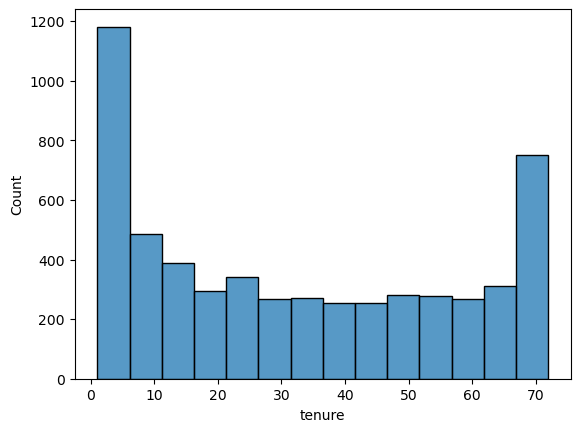

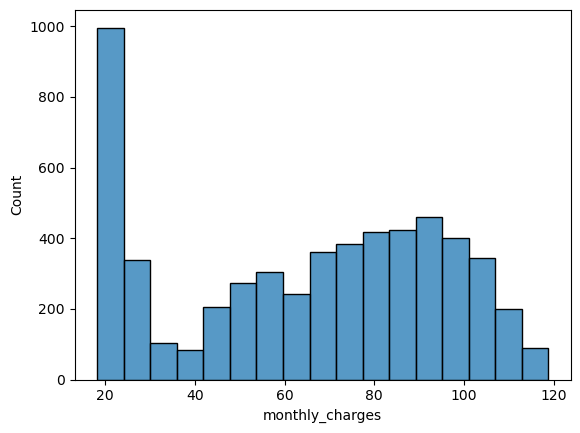

In [17]:
def plot_hist(df):
    list_of_ncolumns = list(df.select_dtypes(np.number))
    #list with numeric columns names
    for col in list_of_ncolumns:
        sns.histplot(df[col])
        plt.show()
        
plot_hist(x_tr_n)

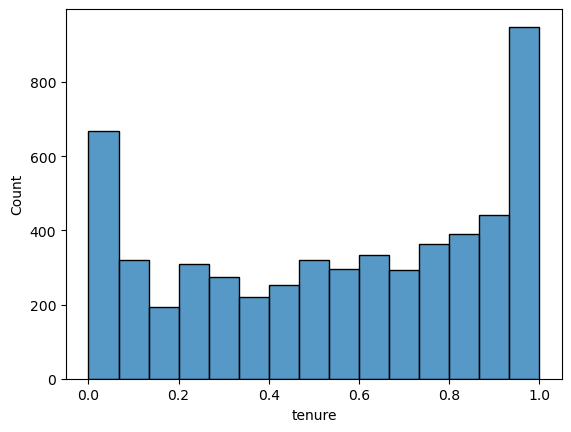

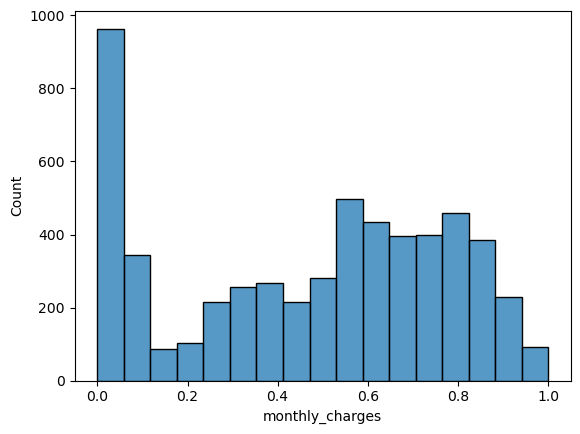

In [18]:
# Scaling numerical data
transformer = PowerTransformer().fit(x_tr_n)

x_tr_nnorm = pd.DataFrame(transformer.transform(x_tr_n), columns = x_tr_n.columns)
x_te_nnorm = pd.DataFrame(transformer.transform(x_te_n), columns = x_te_n.columns)

transformer = MinMaxScaler().fit(x_tr_nnorm)

x_tr_nnorm = pd.DataFrame(transformer.transform(x_tr_nnorm), columns = x_tr_n.columns)
x_te_nnorm = pd.DataFrame(transformer.transform(x_te_nnorm), columns = x_te_n.columns)

plot_hist(x_tr_nnorm)

### transforming categorical data

In [19]:
# Transforming categorical data
#from sklearn.preprocessing import OneHotEncoder

#encoder = OneHotEncoder(drop='first').fit(x_tr_c)

#x_tr_c = encoder.transform(x_tr_c).toarray()
#x_te_c = encoder.transform(x_te_c).toarray()

#x_tr_c = pd.DataFrame(x_tr_c, columns = encoder.get_feature_names_out())
#x_te_c = pd.DataFrame(x_te_c, columns = encoder.get_feature_names_out())

In [20]:
x_tr_c.value_counts()
#already one hot encoded

senior_citizen
0                 4721
1                  904
dtype: int64

### Joining numerical-categorical

In [21]:
x_tr_f = np.concatenate([x_tr_nnorm, x_tr_c], axis=1)
x_te_f = np.concatenate([x_te_nnorm, x_te_c], axis=1)

## 7. Build the logistic regression model.

In [22]:
lr = LogisticRegression(random_state=0, solver='lbfgs',
                          max_iter=1000, multi_class='multinomial')

lr.fit(x_tr_f, y_tr)
y_te_pr = lr.predict(x_te_f)

## 6. Evaluate the model.

In [25]:
print("score is", lr.score(x_te_f,y_te))
print("coher_kappa score is", cohen_kappa_score(y_te, y_te_pr))
print(classification_report(y_te, y_te_pr, zero_division = 0))

score is 0.7839374555792467
coher_kappa score is 0.3868208808443169
              precision    recall  f1-score   support

          No       0.82      0.91      0.86      1033
         Yes       0.63      0.44      0.52       374

    accuracy                           0.78      1407
   macro avg       0.73      0.67      0.69      1407
weighted avg       0.77      0.78      0.77      1407



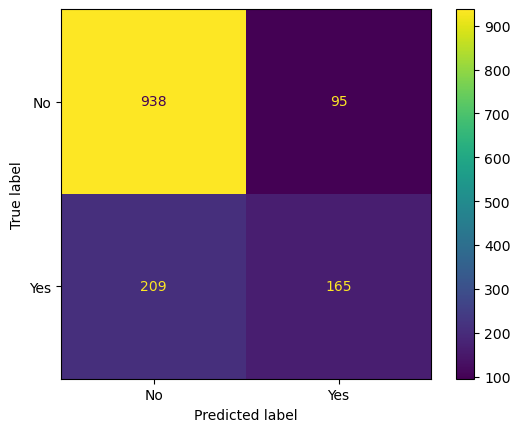

In [26]:
conf_mat = confusion_matrix(y_te, y_te_pr)
ConfusionMatrixDisplay(conf_mat, display_labels=lr.classes_).plot()

## 7. Even a simple model will give us more than 70% accuracy. Why?

In [27]:
len(data[data['churn'] == 'Yes'])/len(data)*100
#imbalaced data

26.578498293515356

## 8. Synthetic Minority Oversampling TEchnique (SMOTE) (...). Is it there any improvement?

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html?highlight=smote#imblearn.over_sampling.SMOTE

SMOTENC
Over-sample using SMOTE for continuous and categorical features.

tried this instead of SMOTE

In [28]:
sm = SMOTENC(random_state=42,k_neighbors=5, categorical_features=[2])

x_tr_SMOTE,y_tr_SMOTE = sm.fit_resample(x_tr_f,y_tr)

print(x_tr.shape)
print(x_tr_SMOTE.shape)
y_tr_SMOTE.value_counts()

(5625, 3)
(8260, 3)


Yes    4130
No     4130
Name: churn, dtype: int64

In [31]:
lr = LogisticRegression(random_state=0, solver='lbfgs',
                          max_iter=1000, multi_class='multinomial')

lr.fit(x_tr_SMOTE, y_tr_SMOTE)
y_te_pred = lr.predict(x_te.values)

print("score is", lr.score(x_te.values,y_te))
print("coher_kappa score is", cohen_kappa_score(y_te, y_te_pred))
print(classification_report(y_te, y_te_pred, zero_division = 0))

score is 0.7569296375266524
coher_kappa score is 0.39075331278851577
              precision    recall  f1-score   support

          No       0.84      0.82      0.83      1033
         Yes       0.54      0.58      0.56       374

    accuracy                           0.76      1407
   macro avg       0.69      0.70      0.70      1407
weighted avg       0.76      0.76      0.76      1407



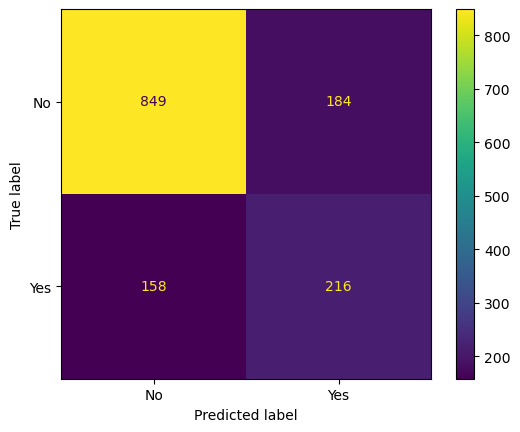

In [33]:
conf_mat = confusion_matrix(y_te, y_te_pred)
ConfusionMatrixDisplay(conf_mat, display_labels=lr.classes_).plot()

there is some improvement: cohen kappa is higher, churn == yes is predicted more correctly